In [1]:
elastic_rods_dir = '../../../../elastic_rods/python/'
weaving_dir = '../../../'
import os
import os.path as osp
import sys; sys.path.append(elastic_rods_dir); sys.path.append(weaving_dir)
import numpy as np, elastic_rods, linkage_vis
import numpy.linalg as la
from bending_validation import suppress_stdout as so
import matplotlib.pyplot as plt
from elastic_rods import EnergyType, InterleavingType

# weaving
import analysis_helper, ribbon_linkage_helper, mesh_vis, linkage_utils, compute_curve_from_curvature, pipeline_helper, importlib
importlib.reload(analysis_helper)
importlib.reload(ribbon_linkage_helper)
importlib.reload(mesh_vis)
importlib.reload(linkage_utils)
importlib.reload(compute_curve_from_curvature)
importlib.reload(pipeline_helper)
from analysis_helper import (compare_turning_angle,
                            is_on_sphere, 
                            get_distance_to_center_scalar_field, 
                            plot_curvatures, 
                            get_curvature_scalar_field,
                            construct_elastic_rod_loop_from_rod_segments, 
                            concatenate_rod_properties_from_rod_segments, 
                            compute_min_distance_rigid_transformation)
from ribbon_linkage_helper import (update_rest_curvature, 
                                   set_ribbon_linkage,
                                   export_linkage_geometry_to_obj,
                                   write_linkage_ribbon_output_florin)

from compute_curve_from_curvature import (match_geo_curvature_and_edge_len, get_all_curve_pattern)
from linkage_utils import order_segments_by_ribbons, get_turning_angle_and_length_from_ordered_rods

from pipeline_helper import (initialize_linkage, get_normal_deviation, set_joint_vector_field, stage_1_optimization, initialize_stage_2_optimizer, stage_2_optimization, InputOrganizer, write_all_output, set_surface_view_options, get_structure_analysis_view, get_max_distance_to_target_surface, contact_optimization, show_selected_joints, get_fixed_boundary_joint)

import vis.fields
import matplotlib.cm as cm
import time

In [2]:
import parallelism
parallelism.set_max_num_tbb_threads(12)
parallelism.set_hessian_assembly_num_threads(4)
parallelism.set_gradient_assembly_num_threads(4)

In [3]:
rod_length = 0.05979705114046488
width = rod_length / 20 * 5
thickness = width / 5 * 0.35
print(width, thickness)
io = InputOrganizer('bird_close_beak_1', thickness, width, weaving_dir)

0.01494926278511622 0.0010464483949581352


In [4]:
import py_newton_optimizer
OPTS = py_newton_optimizer.NewtonOptimizerOptions()
OPTS.gradTol = 1e-6
OPTS.verbose = 1;
OPTS.beta = 1e-8
OPTS.niter = 200
OPTS.verboseNonPosDef = False
rw = 1
sw = 10
drw = 0.1
dsw = 0.1

In [5]:
rw = 1
sw = 10
dsw = 0.01
drw = 0.01

In [6]:
with so(): curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = True, model_path = io.MODEL_PATH, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION, use_constant_width = True)
curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
curved_save_tgt_joint_pos = curved_linkage.jointPositions();
curved_linkage_view = linkage_vis.LinkageViewerWithSurface(curved_linkage, io.SURFACE_PATH)
set_surface_view_options(curved_linkage_view)
curved_linkage_view.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), quaternion=(…

In [7]:
curved_linkage.setDesignParameters(np.load('results/bird_close_beak_1/bird_close_beak_1_dof.npy')[curved_linkage.numDoF():])

In [8]:
curved_linkage.attraction_weight = 1e-5

In [9]:
# iterateData = stage_1_optimization(curved_linkage, 0.1, 0.1, curved_linkage_view)

In [10]:
def eqm_callback(prob, i):
    curved_linkage_view.update()

In [11]:
OPTS.niter = 10000

In [12]:
elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS, fixedVars = [])

0	0.00184088	0.852752	0.852752	1	1
1	0.00108278	0.200086	0.200086	1	1
2	0.000868795	0.098949	0.098949	1	1
3	0.000730063	0.0582822	0.0582822	1	1
4	0.00068843	0.0479218	0.0479218	1	1
5	0.000633604	0.0374152	0.0374152	1	1
6	0.000611958	0.0336967	0.0336967	1	1
7	0.000577815	0.0289609	0.0289609	1	1
8	0.000563073	0.0270776	0.0270776	1	1
9	0.000537975	0.0243721	0.0243721	1	1
10	0.000498131	0.0211383	0.0211383	1	1
11	0.000481902	0.0193587	0.0193587	1	1
12	0.000455211	0.0173399	0.0173399	1	1
13	0.000443395	0.0164961	0.0164961	1	1
14	0.000422816	0.0151894	0.0151894	1	1
15	0.000413442	0.0146158	0.0146158	1	1
16	0.000396628	0.0136868	0.0136868	1	1
17	0.000388825	0.013267	0.013267	1	1
18	0.00037455	0.0125636	0.0125636	1	1
19	0.000349521	0.0115766	0.0115766	1	1
20	0.00033839	0.0110302	0.0110302	1	1
21	0.000317995	0.0102565	0.0102565	1	1
22	0.000309384	0.00970459	0.00970459	1	1
23	0.000294767	0.00891253	0.00891253	1	1
24	0.000271632	0.00794753	0.00794753	1	1
25	0.000261699	0.00750176	0.00750176	1	1
2

In [13]:
optimizer = initialize_stage_2_optimizer(curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, rw, sw,  fixed_boundary_joint = [])

In [14]:
optimizer.setLinkageAttractionWeight(1e-5)

In [15]:
# optimizer, opt_iterateData = stage_2_optimization(optimizer, curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, -1, -3, 3)

In [16]:
# deviation, deviation_vector, joint_normals, joint_projection_normals = get_normal_deviation(curved_linkage)

In [17]:
# set_joint_vector_field(curved_linkage, curved_linkage_view, joint_normals)

In [18]:
curved_linkage.attraction_weight = 1e-5

../../../../elastic_rods/python/structural_analysis.py:213: RuntimeWarning: invalid value encountered in true_divide
  coefficientOfFriction = cfm[:, 1] / (-separationForce)
/Users/yren/Library/Python/3.7/lib/python/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/yren/Library/Python/3.7/lib/python/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Coefficient of Friction Percentiles 50, 75, 90:  nan nan nan


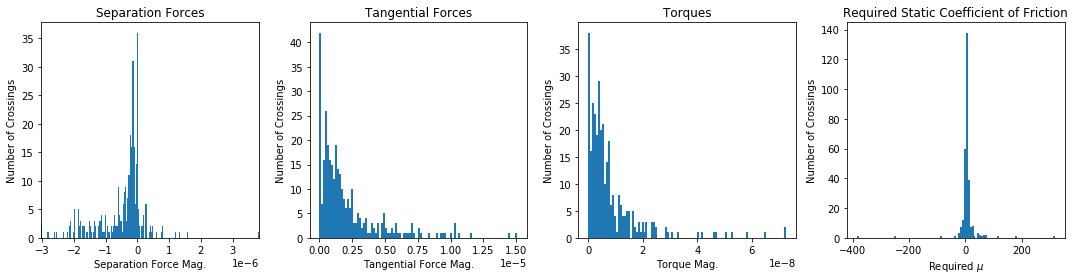

In [19]:
structure_view = get_structure_analysis_view(curved_linkage)
structure_view.show()

In [20]:
# save_path = os.getcwd()
# write_all_output(curved_linkage, io.SUBDIVISION_RESOLUTION, io.MODEL_NAME, io.RIBBON_NAME, False, 100, min(io.RIBBON_CS), target_width = 5, flip_angles = True, width = max(io.RIBBON_CS))
# os.chdir(save_path)

In [21]:
import structural_analysis
cfm = structural_analysis.weavingCrossingForceMagnitudes(curved_linkage, True)

In [22]:
cfm[106, 0]

1.8773755555555756e-07

In [42]:
np.sum((cfm[:, 0] > 0))

36

In [27]:
def get_opposite_joint_type(curr_type):
    if curr_type == curved_linkage.joint(0).Type.A_OVER_B:
        return curved_linkage.joint(0).Type.B_OVER_A
    return curved_linkage.joint(0).Type.A_OVER_B

In [28]:
def get_opposite_joint_type(curr_type):
    if curr_type == curved_linkage.joint(0).Type.A_OVER_B:
        return curved_linkage.joint(0).Type.B_OVER_A
    return curved_linkage.joint(0).Type.A_OVER_B
import structural_analysis
cfm = structural_analysis.weavingCrossingForceMagnitudes(curved_linkage, True)
for i in np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):]:
    curved_linkage.joint(i).type = get_opposite_joint_type(curved_linkage.joint(i).type)

In [23]:
# optimizer.beta = 1e6

In [24]:
optimizer, contact_opt_iterateData = contact_optimization(optimizer, curved_linkage, curved_linkage_view, -1, contact_weight = 1e6, normalWeight = 10, torqueWeight = 0, normalActivationThreshold=-1e-6)

In [25]:
# np.save('bird_contact_opt_20201110.npy', curved_linkage.getExtendedDoFsPSRL())

Coefficient of Friction Percentiles 50, 75, 90:  nan nan nan


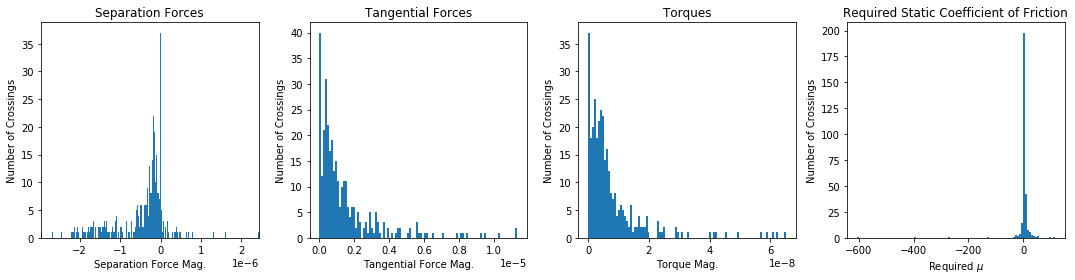

In [26]:
structure_view_2 = get_structure_analysis_view(curved_linkage)
structure_view_2.show()

In [ ]:
contact_forces = [curr_iter['ContactForce'] for curr_iter in contact_opt_iterateData]

In [ ]:
elastic_energys = [curr_iter['ElasticEnergy'] for curr_iter in contact_opt_iterateData]

In [ ]:
target_fitting = [curr_iter['TargetFitting'] for curr_iter in contact_opt_iterateData]

In [ ]:
plt.plot(contact_forces)

In [ ]:
plt.plot(elastic_energys)

In [ ]:
plt.plot(target_fitting)

In [ ]:
# contact_optimization(optimizer, curved_linkage_view, -1, 1e6)

In [ ]:
# structure_view_3 = get_structure_analysis_view(curved_linkage)
# structure_view_3.show()

In [ ]:
# contact_optimization(optimizer, curved_linkage_view, -1, 1e8, -1e-3)

In [ ]:
# structure_view_4 = get_structure_analysis_view(curved_linkage)
# structure_view_4.show()

In [ ]:
# la.norm((curved_linkage.getExtendedDoFsPSRL() - np.load('results/bird_close_beak_1/bird_close_beak_1_dof.npy'))[curved_linkage.restLenOffset():]) / la.norm(curved_linkage.getExtendedDoFsPSRL()[curved_linkage.restLenOffset():])

In [ ]:
# la.norm((curved_linkage.getExtendedDoFsPSRL() - np.load('results/bird_close_beak_1/bird_close_beak_1_dof.npy'))) / la.norm(curved_linkage.getExtendedDoFsPSRL())